# Explore Fredholm-LLM Dataset

This notebook explores the Fredholm-LLM dataset containing ~500,000 Fredholm integral equations of the second kind.

**Dataset Source:** [Zenodo DOI: 10.5281/zenodo.16784707](https://doi.org/10.5281/zenodo.16784707)

**Equation form:** $u(x) - \lambda \int_a^b K(x, t) u(t) dt = f(x)$

## Contents
1. Load and inspect the dataset
2. Analyze equation statistics  
3. Explore expression types
4. Visualize data distributions
5. Display sample equations

In [1]:
# Import required libraries
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path (handle both notebook and script execution)
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    project_root = notebook_dir.parent
else:
    # Try to find project root by looking for pyproject.toml
    project_root = notebook_dir
    while project_root.parent != project_root:
        if (project_root / "pyproject.toml").exists():
            break
        project_root = project_root.parent

sys.path.insert(0, str(project_root))

# Import project modules
from src.data.fredholm_loader import FredholmDatasetLoader, ExpressionType

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print(f"Project root: {project_root}")

Project root: c:\Users\ammah\Documents\GitHub\fred-llm


## Configuration

Set the paths to the datasets you want to explore.

In [2]:
# Dataset paths configuration
# Change these to explore different datasets

# Original dataset - choose one:
# Option 1: Sample dataset (5,000 equations)
ORIGINAL_DATASET_PATH = "raw/Fredholm_Dataset_Sample.csv"
# Option 2: Full dataset
# ORIGINAL_DATASET_PATH = "raw/Fredholm_Dataset.csv"

# Augmented dataset path - using the new prepared dataset structure
AUGMENTED_DATASET_PATH = "processed/training_data/augmented/Fredholm_Dataset_Sample_augmented.csv"

print(f"📁 Configuration:")
print(f"  Original dataset: data/{ORIGINAL_DATASET_PATH}")
print(f"  Augmented dataset: data/{AUGMENTED_DATASET_PATH}")

📁 Configuration:
  Original dataset: data/raw/Fredholm_Dataset_Sample.csv
  Augmented dataset: data/processed/training_data/augmented/Fredholm_Dataset_Sample_augmented.csv


## 1. Load Dataset

Load the Fredholm-LLM dataset using the specialized loader. If not downloaded yet, run:
```bash
python -m src.cli dataset download --variant sample
```

In [3]:
# Load the dataset using configured path
data_dir = project_root / "data"
dataset_path = data_dir / ORIGINAL_DATASET_PATH

if not dataset_path.exists():
    raise FileNotFoundError(
        f"Dataset not found at: {dataset_path}\n"
        "Please run:\n"
        "  python -m src.cli dataset download --variant sample"
    )

# Load as DataFrame for exploration
df = pd.read_csv(dataset_path)
print(f"✓ Loaded dataset: {len(df):,} equations")
print(f"  Path: {dataset_path.relative_to(project_root)}")

# Also load as FredholmEquation objects
loader = FredholmDatasetLoader(data_path=dataset_path, max_samples=1000)
equations = loader.load()
print(f"\nLoaded {len(equations)} equations as FredholmEquation objects")

✓ Loaded dataset: 5,000 equations
  Path: data\raw\Fredholm_Dataset_Sample.csv
2026-01-02 14:10:21 | INFO     | src.data.fredholm_loader | Loading Fredholm dataset from c:\Users\ammah\Documents\GitHub\fred-llm\data\raw\Fredholm_Dataset_Sample.csv
2026-01-02 14:10:21 | INFO     | src.data.fredholm_loader | Loaded 5000 rows from CSV


Output()

2026-01-02 14:10:23 | INFO     | src.data.fredholm_loader | Loaded 1000 valid equations

Loaded 1000 equations as FredholmEquation objects


## 2. Dataset Overview

Examine the structure and basic statistics of the dataset.

In [4]:
# Dataset Schema Overview
schema_data = {
    'Column': df.columns.tolist(),
    'Type': [str(df[col].dtype) for col in df.columns],
    'Non-Null': [df[col].notna().sum() for col in df.columns],
    'Sample Value': [str(df[col].iloc[0])[:50] + '...' if len(str(df[col].iloc[0])) > 50 else str(df[col].iloc[0]) for col in df.columns]
}
schema_df = pd.DataFrame(schema_data)
display(schema_df)

# Expression length statistics
expr_stats = []
for col in ['u', 'f', 'kernel']:
    lengths = df[col].str.len()
    expr_stats.append({
        'Expression': col,
        'Min Length': lengths.min(),
        'Max Length': lengths.max(),
        'Mean Length': f"{lengths.mean():.1f}",
        'Median': lengths.median()
    })
display(pd.DataFrame(expr_stats))

,Column,Type,Non-Null,Sample Value
0,u,object,5000,x**2
1,f,object,5000,x**2 + 67.43530567990815*x - 228.3357446212934
2,kernel,object,5000,x - 3.385997028101621
3,lambda,float64,5000,-1.41556822867895
4,a,float64,5000,6.330207264818775
5,b,float64,5000,7.346979435881526


,Expression,Min Length,Max Length,Mean Length,Median
0,u,1,146,21.0,17.0
1,f,2,9896,77.9,55.0
2,kernel,2,186,29.3,25.0


## 3. Expression Type Analysis

Analyze the types of mathematical expressions in the dataset (polynomial, trigonometric, hyperbolic, exponential).

,Type,u(x) Count,u(x) %,"K(x,t) Count","K(x,t) %",f(x) Count,f(x) %
0,real_value,255,25.5%,81,8.1%,46,4.6%
1,polynomial,486,48.6%,231,23.1%,181,18.1%
2,trigonometric,85,8.5%,233,23.3%,247,24.7%
3,hyperbolic,90,9.0%,271,27.1%,306,30.6%
4,exponential,84,8.4%,184,18.4%,220,22.0%


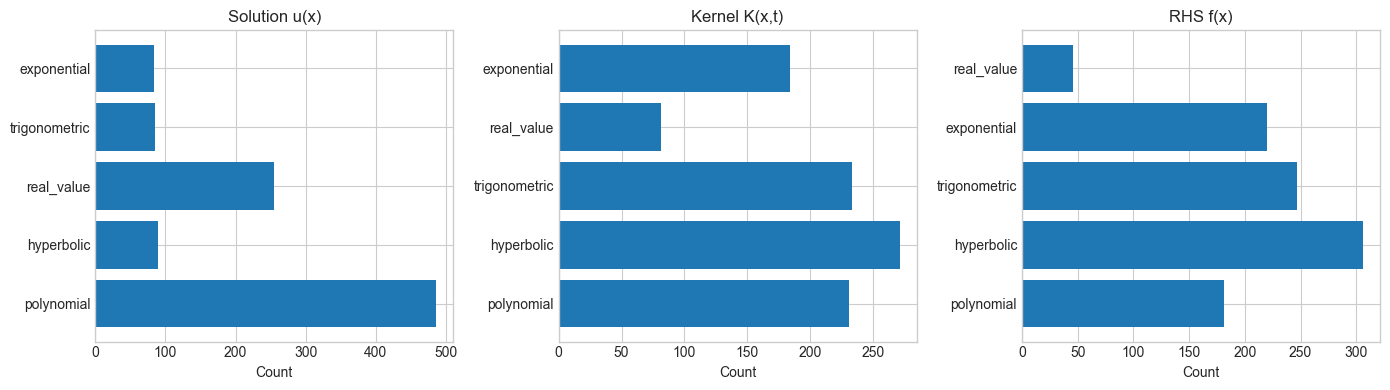

In [5]:
# Count expression types
from collections import Counter

u_types = Counter(eq.metadata.get('u_type', ExpressionType.REAL_VALUE) for eq in equations)
kernel_types = Counter(eq.metadata.get('kernel_type', ExpressionType.REAL_VALUE) for eq in equations)
f_types = Counter(eq.metadata.get('f_type', ExpressionType.REAL_VALUE) for eq in equations)

# Create summary table
total = len(equations)
type_summary = []
for expr_type in ExpressionType:
    type_summary.append({
        'Type': expr_type.value,
        'u(x) Count': u_types.get(expr_type, 0),
        'u(x) %': f"{100 * u_types.get(expr_type, 0) / total:.1f}%",
        'K(x,t) Count': kernel_types.get(expr_type, 0),
        'K(x,t) %': f"{100 * kernel_types.get(expr_type, 0) / total:.1f}%",
        'f(x) Count': f_types.get(expr_type, 0),
        'f(x) %': f"{100 * f_types.get(expr_type, 0) / total:.1f}%",
    })
display(pd.DataFrame(type_summary))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (title, types) in zip(axes, [('Solution u(x)', u_types), ('Kernel K(x,t)', kernel_types), ('RHS f(x)', f_types)]):
    labels = [t.value for t in types.keys()]
    ax.barh(labels, list(types.values()))
    ax.set_xlabel('Count')
    ax.set_title(title)
plt.tight_layout()
plt.show()

## 4. Numerical Parameters Distribution

Analyze the distribution of λ (lambda) parameter and integration bounds [a, b].

,Parameter,Min,Max,Mean,Std
0,λ,-10.000,10.000,-0.081,5.760
1,Lower bound (a),-9.998,9.707,-3.264,4.825
2,Upper bound (b),-9.945,9.999,3.208,4.797


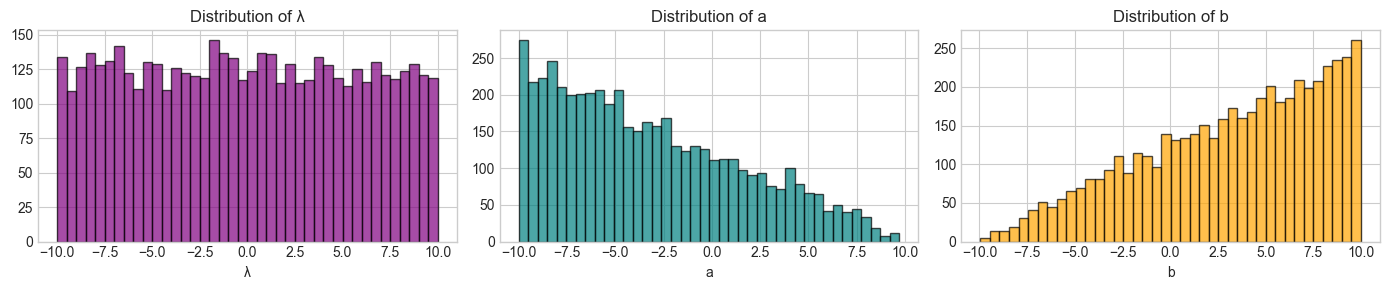

In [6]:
# Numerical parameters statistics
stats_data = []
for col, label in [('lambda', 'λ'), ('a', 'Lower bound (a)'), ('b', 'Upper bound (b)')]:
    col_data = pd.to_numeric(df[col], errors='coerce')
    stats_data.append({
        'Parameter': label,
        'Min': f"{col_data.min():.3f}",
        'Max': f"{col_data.max():.3f}",
        'Mean': f"{col_data.mean():.3f}",
        'Std': f"{col_data.std():.3f}"
    })
display(pd.DataFrame(stats_data))

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for ax, (col, label, color) in zip(axes, [('lambda', 'λ', 'purple'), ('a', 'a', 'teal'), ('b', 'b', 'orange')]):
    ax.hist(pd.to_numeric(df[col], errors='coerce').dropna(), bins=40, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(label)
    ax.set_title(f'Distribution of {label}')
plt.tight_layout()
plt.show()

## 5. Solution Characteristics

Analyze the types of solutions in the dataset: exact symbolic, special functions, constants, etc.

,Solution Type,Count,Percentage
0,Constant,1337,26.7%
1,Polynomial,1318,26.4%
2,Linear (x),923,18.5%
3,Hyperbolic,443,8.9%
4,Trigonometric,421,8.4%
5,Exponential,398,8.0%
6,Other Symbolic,90,1.8%
7,Trivial (zero),44,0.9%
8,Rational,26,0.5%


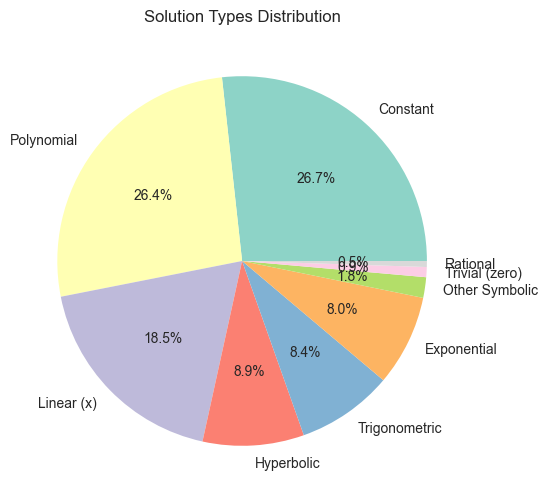

In [7]:
import re

def classify_solution(u_expr: str) -> str:
    """Classify solution type based on expression."""
    u = u_expr.strip().lower()
    
    # Check for no solution / trivial
    if u in ['0', '0.0', 'none', 'null', '']:
        return 'Trivial (zero)'
    
    # Check for constant
    if re.match(r'^-?\d+\.?\d*$', u):
        return 'Constant'
    
    # Check for simple variable
    if u in ['x', 't']:
        return 'Linear (x)'
    
    # Check for special functions
    if any(fn in u for fn in ['bessel', 'legendre', 'hermite', 'laguerre', 'gamma', 'erf']):
        return 'Special Function'
    
    # Check for exponential
    if 'exp(' in u:
        return 'Exponential'
    
    # Check for hyperbolic
    if any(fn in u for fn in ['sinh', 'cosh', 'tanh']):
        return 'Hyperbolic'
    
    # Check for trigonometric
    if any(fn in u for fn in ['sin', 'cos', 'tan']):
        return 'Trigonometric'
    
    # Check for polynomial
    if '**' in u or (re.search(r'x\s*\*', u) or re.search(r'\*\s*x', u)):
        return 'Polynomial'
    
    # Check for rational
    if '/' in u and 'x' in u:
        return 'Rational'
    
    return 'Other Symbolic'

# Classify all solutions
df['solution_type'] = df['u'].apply(classify_solution)
solution_counts = df['solution_type'].value_counts()

# Display as table
solution_table = pd.DataFrame({
    'Solution Type': solution_counts.index,
    'Count': solution_counts.values,
    'Percentage': [f"{100*c/len(df):.1f}%" for c in solution_counts.values]
})
display(solution_table)

# Pie chart
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Set3(range(len(solution_counts)))
ax.pie(solution_counts.values, labels=solution_counts.index, autopct='%1.1f%%', colors=colors)
ax.set_title('Solution Types Distribution')
plt.show()

## 6. Sample Equations

Display sample equations from each solution type in a clean format.

In [8]:
# Show sample equations from each solution type
n_samples = 3

for sol_type in df['solution_type'].unique():
    subset = df[df['solution_type'] == sol_type].head(n_samples)
    print(f"\n{'='*60}")
    print(f"Solution Type: {sol_type.upper()} ({len(df[df['solution_type'] == sol_type])} total)")
    print('='*60)
    
    for idx, row in subset.iterrows():
        print(f"\nEquation #{idx}:")
        print(f"  u(x) = {row['u']}")
        print(f"  f(x) = {row['f']}")
        print(f"  K(x,t) = {row['kernel']}")
        print(f"  λ = {row['lambda']}, a = {row['a']}, b = {row['b']}")


Solution Type: POLYNOMIAL (1318 total)

Equation #0:
  u(x) = x**2
  f(x) =  x**2 + 67.43530567990815*x - 228.3357446212934
  K(x,t) =  x - 3.385997028101621
  λ = -1.41556822867895, a = 6.330207264818775, b = 7.346979435881526

Equation #4:
  u(x) = x**2
  f(x) =  x**2 + 1546.28460070784*exp(cosh(x**4 + x - x/tanh(x)))
  K(x,t) =  exp(cosh(x**4 + x - x/tanh(x)))
  λ = -7.547666688954335, a = -0.0657874199274282, b = 8.502224933442758

Equation #11:
  u(x) = x**2
  f(x) =  x**2 + 4.76404256216086
  K(x,t) =  exp(t)
  λ = -2.3033965858276817, a = -9.374643881594206, b = 0.5367211877695937

Solution Type: LINEAR (X) (923 total)

Equation #1:
  u(x) = x
  f(x) =  -29.1312154546274*x**3 + x + 29.1312154546274*cosh(x**2) - 154.644350903536
  K(x,t) =  t**2*cos(t) - x**3 + cosh(x**2)
  λ = 2.4118892447844527, a = -5.042949070174741, b = -1.1291542887908277

Equation #2:
  u(x) = x
  f(x) =  215.447494768274*x**7*cos(x)**2 + x
  K(x,t) =  x**7*cos(x)**2
  λ = -6.118629011112871, a = -3.16679

## 7. Explore Augmented Datasets

Analyze augmented datasets with edge case strategies to understand the distribution of different equation types.

In [9]:
# Load augmented dataset using configured path
augmented_path = project_root / "data" / AUGMENTED_DATASET_PATH

if augmented_path.exists():
    print(f"✓ Loading augmented dataset from: {augmented_path.relative_to(project_root)}")
    
    # Read with keep_default_na=False to preserve empty strings
    aug_df = pd.read_csv(augmented_path, keep_default_na=False)
    
    print(f"  Loaded {len(aug_df):,} augmented equations")
    print(f"  Columns: {len(aug_df.columns)}")
    
    # Show key column groups
    core_cols = ['u', 'f', 'kernel', 'lambda_val', 'a', 'b']
    aug_cols = ['augmented', 'augmentation_type', 'augmentation_variant']
    meta_cols = ['has_solution', 'solution_type', 'edge_case', 'reason']
    print(f"\n  Core fields: {', '.join(core_cols)}")
    print(f"  Augmentation tracking: {', '.join(aug_cols)}")
    print(f"  Metadata: {', '.join(meta_cols)}")
else:
    print(f"❌ Augmented dataset not found at: {augmented_path.relative_to(project_root)}")
    print("\nTo generate augmented data, run:")
    print("  python scripts/prepare_dataset.py --input data/raw/Fredholm_Dataset_Sample.csv \\")
    print("    --output data/processed/training_data --augment \\")
    print("    --augment-strategies no_solution numerical_only regularization_required non_unique_solution")
    aug_df = None

✓ Loading augmented dataset from: data\processed\training_data\augmented\Fredholm_Dataset_Sample_augmented.csv
  Loaded 5,767 augmented equations
  Columns: 87

  Core fields: u, f, kernel, lambda_val, a, b
  Augmentation tracking: augmented, augmentation_type, augmentation_variant
  Metadata: has_solution, solution_type, edge_case, reason


### 7.1 Augmentation Type Distribution

Analyze the distribution of original vs augmented equations and different augmentation strategies.

Augmentation Type Distribution:


,Augmentation Type,Count,Percentage
0,original,5000,86.7%
1,range_violation,72,1.2%
2,divergent_kernel,72,1.2%
3,approximate_only,72,1.2%
4,mixed_type,72,1.2%
5,weakly_singular,72,1.2%
6,boundary_layer,72,1.2%
7,oscillatory_solution,72,1.2%
8,compact_support,72,1.2%
9,ill_posed,69,1.2%



📊 Dataset Balance:
  Original equations: 5,000 (86.7%)
  Augmented variants: 767 (13.3%)
  Augmentation ratio: 0.15x


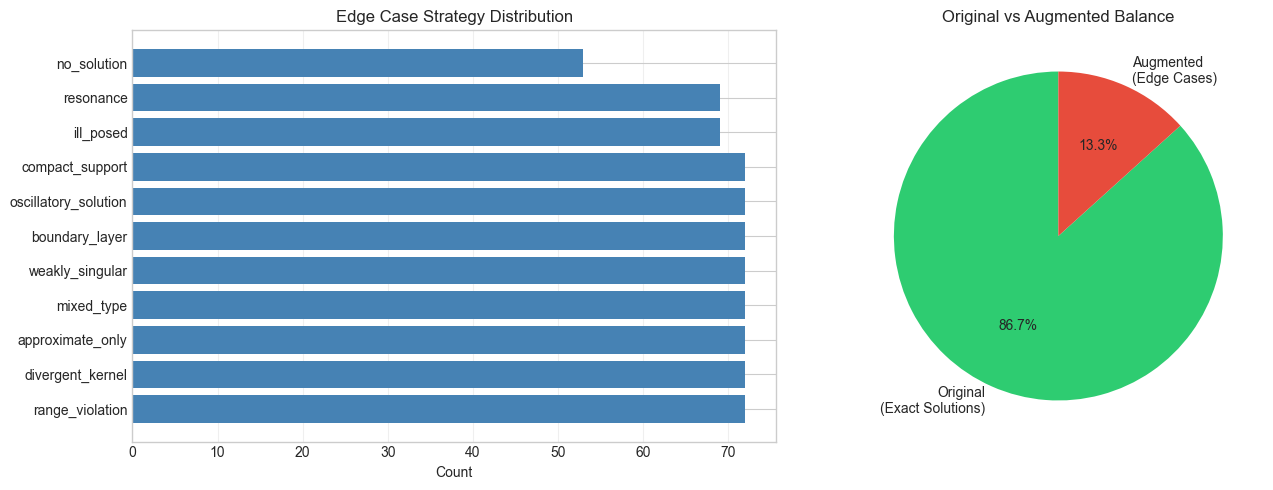

In [10]:
if aug_df is not None:
    # Count augmentation types
    aug_type_counts = aug_df['augmentation_type'].value_counts()
    
    # Create summary table
    aug_summary = pd.DataFrame({
        'Augmentation Type': aug_type_counts.index,
        'Count': aug_type_counts.values,
        'Percentage': [f"{100*c/len(aug_df):.1f}%" for c in aug_type_counts.values]
    })
    print("Augmentation Type Distribution:")
    display(aug_summary)
    
    # Calculate balance
    original_count = (aug_df['augmented'] == False).sum()
    augmented_count = (aug_df['augmented'] == True).sum()
    
    print(f"\n📊 Dataset Balance:")
    print(f"  Original equations: {original_count:,} ({100*original_count/len(aug_df):.1f}%)")
    print(f"  Augmented variants: {augmented_count:,} ({100*augmented_count/len(aug_df):.1f}%)")
    print(f"  Augmentation ratio: {augmented_count/original_count:.2f}x")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of augmentation strategies
    strategy_counts = aug_df[aug_df['augmented'] == True]['augmentation_type'].value_counts()
    axes[0].barh(strategy_counts.index, strategy_counts.values, color='steelblue')
    axes[0].set_xlabel('Count')
    axes[0].set_title('Edge Case Strategy Distribution')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Pie chart for original vs augmented
    balance_data = [original_count, augmented_count]
    balance_labels = ['Original\n(Exact Solutions)', 'Augmented\n(Edge Cases)']
    colors = ['#2ecc71', '#e74c3c']
    axes[1].pie(balance_data, labels=balance_labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[1].set_title('Original vs Augmented Balance')
    
    plt.tight_layout()
    plt.show()

### 7.2 Edge Case Analysis

Analyze edge case properties: solution existence, solution types, and special characteristics.

📊 Solution Type Distribution:



,Solution Type,Count,Percentage,Description
0,exact,5000,86.7%,Well-posed with symbolic solution
1,numerical,431,7.5%,Requires numerical methods
2,none,221,3.8%,No solution exists
3,regularized,69,1.2%,Requires regularization (ill-posed)
4,family,46,0.8%,Multiple solutions (family)



✅ Solvability:
   Has solution: 0 (0.0%)
   No solution: 0 (0.0%)


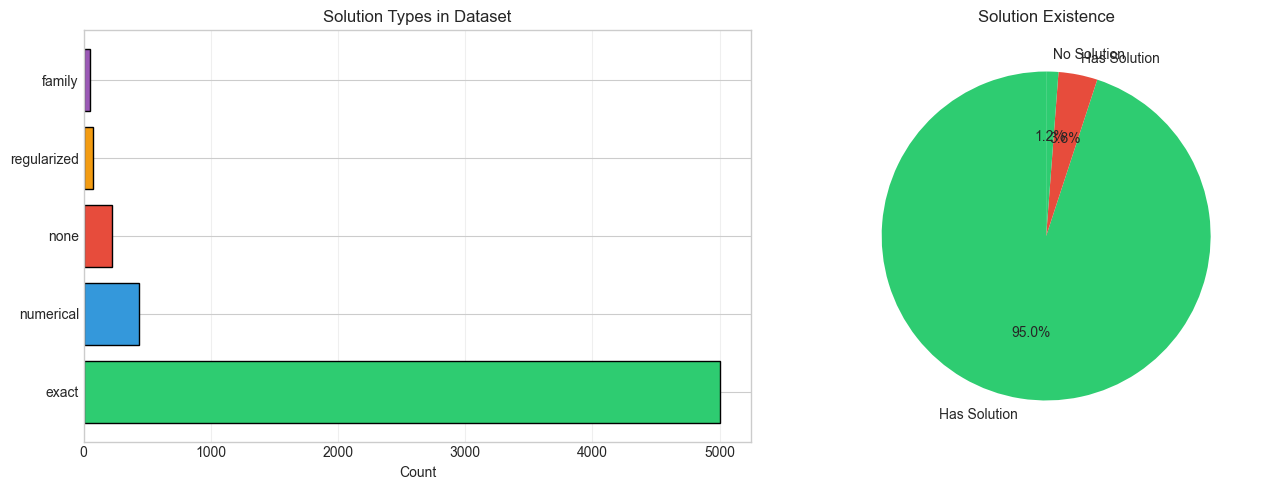

In [11]:
if aug_df is not None:
    # Solution type distribution
    solution_type_counts = aug_df['solution_type'].value_counts()
    
    print(f"📊 Solution Type Distribution:\n")
    
    # Tables
    solution_type_df = pd.DataFrame({
        'Solution Type': solution_type_counts.index,
        'Count': solution_type_counts.values,
        'Percentage': [f"{100*c/len(aug_df):.1f}%" for c in solution_type_counts.values],
        'Description': [
            'Well-posed with symbolic solution' if st == 'exact' else
            'Requires numerical methods' if st == 'numerical' else
            'No solution exists' if st == 'none' else
            'Requires regularization (ill-posed)' if st == 'regularized' else
            'Multiple solutions (family)' if st == 'family' else
            'Unknown'
            for st in solution_type_counts.index
        ]
    })
    display(solution_type_df)
    
    # Has solution analysis
    has_solution_counts = aug_df['has_solution'].value_counts()
    print(f"\n✅ Solvability:")
    print(f"   Has solution: {has_solution_counts.get(True, 0):,} ({100*has_solution_counts.get(True, 0)/len(aug_df):.1f}%)")
    print(f"   No solution: {has_solution_counts.get(False, 0):,} ({100*has_solution_counts.get(False, 0)/len(aug_df):.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Solution type bar chart
    colors_map = {'exact': '#2ecc71', 'numerical': '#3498db', 'none': '#e74c3c', 
                  'regularized': '#f39c12', 'family': '#9b59b6'}
    bar_colors = [colors_map.get(st, '#95a5a6') for st in solution_type_counts.index]
    axes[0].barh(solution_type_counts.index, solution_type_counts.values, color=bar_colors, edgecolor='black')
    axes[0].set_xlabel('Count')
    axes[0].set_title('Solution Types in Dataset')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Solvability pie chart
    axes[1].pie(has_solution_counts.values, 
                labels=[f"{'Has Solution' if k else 'No Solution'}" for k in has_solution_counts.index], 
                autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
    axes[1].set_title('Solution Existence')
    
    plt.tight_layout()
    plt.show()

### 7.3 Edge Case Type Breakdown

Deep dive into specific edge case types: no-solution, approximate-only, and ill-posed equations.

📊 Total edge cases: 767 (13.3% of dataset)



,Edge Case Type,Count,Percentage of Edge Cases,Percentage of Total
0,range_violation,72,9.4%,1.2%
1,divergent_kernel,72,9.4%,1.2%
2,approximate_only,72,9.4%,1.2%
3,weakly_singular,72,9.4%,1.2%
4,compact_support,72,9.4%,1.2%
5,boundary_layer,72,9.4%,1.2%
6,oscillatory_solution,72,9.4%,1.2%
7,mixed_type,72,9.4%,1.2%
8,ill_posed,69,9.0%,1.2%
9,no_solution,53,6.9%,0.9%



📍 Range Violation: 72 equations
   Solution types: none(72)
   Example: f(x) is odd but kernel produces only even functions...

📍 Divergent Kernel: 72 equations
   Solution types: none(72)
   Example: Kernel K(x,t) = 1/|x-t| has non-integrable singularity...

📍 Approximate Only: 72 equations
   Solution types: numerical(72)
   Example: Gaussian kernel has no symbolic antiderivative...

📍 Weakly Singular: 72 equations
   Solution types: numerical(72)
   Example: ...

📍 Compact Support: 72 equations
   Solution types: numerical(48), none(24)
   Example: ...

📍 Boundary Layer: 72 equations
   Solution types: numerical(72)
   Example: ...

📍 Oscillatory Solution: 72 equations
   Solution types: numerical(72)
   Example: ...

📍 Mixed Type: 72 equations
   Solution types: numerical(72)
   Example: ...

📍 Ill Posed: 69 equations
   Solution types: regularized(69)
   Example: First kind equation - extremely sensitive to noise in f(x)...

📍 No Solution: 53 equations
   Solution types: none(53)

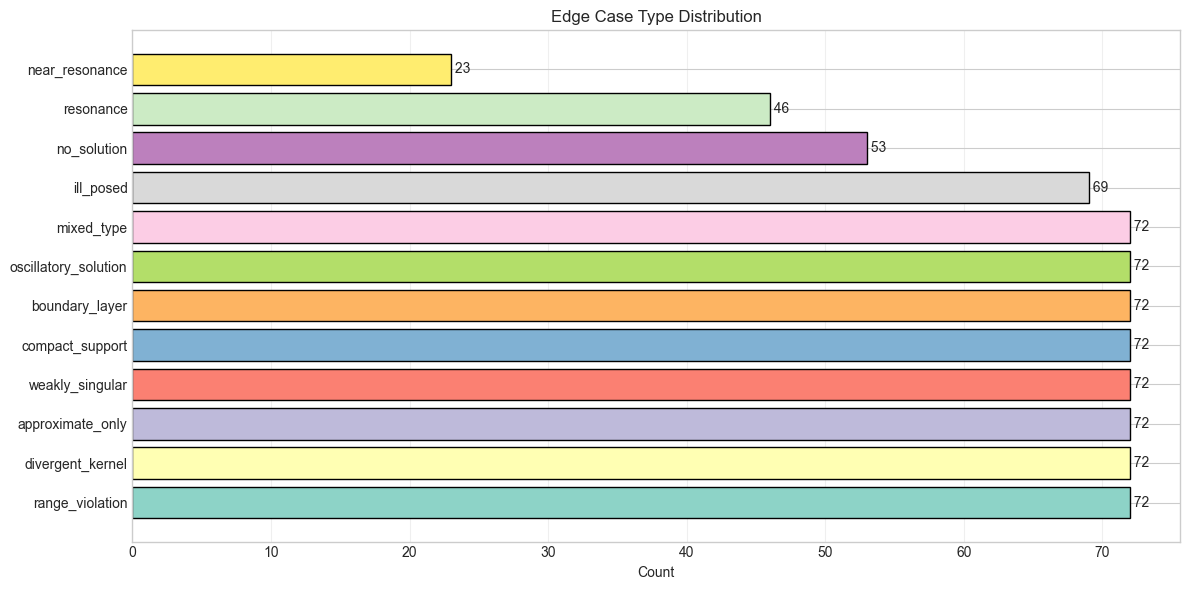

In [12]:
if aug_df is not None:
    # Filter augmented cases with edge cases
    edge_cases = aug_df[aug_df['edge_case'].notna() & (aug_df['edge_case'] != '')]
    
    if len(edge_cases) > 0:
        print(f"📊 Total edge cases: {len(edge_cases):,} ({100*len(edge_cases)/len(aug_df):.1f}% of dataset)\n")
        
        # Count each edge case type
        edge_case_types = edge_cases['edge_case'].value_counts()
        
        # Summary table
        edge_type_summary = pd.DataFrame({
            'Edge Case Type': edge_case_types.index,
            'Count': edge_case_types.values,
            'Percentage of Edge Cases': [f"{100*c/len(edge_cases):.1f}%" for c in edge_case_types.values],
            'Percentage of Total': [f"{100*c/len(aug_df):.1f}%" for c in edge_case_types.values]
        })
        display(edge_type_summary)
        
        # Analyze characteristics of top edge types
        print()
        for edge_type in edge_case_types.head(12).index:
            subset = edge_cases[edge_cases['edge_case'] == edge_type]
            solution_types = subset['solution_type'].value_counts()
            
            print(f"📍 {edge_type.replace('_', ' ').title()}: {len(subset):,} equations")
            print(f"   Solution types: {', '.join([f'{st}({cnt})' for st, cnt in solution_types.items()])}")
            
            # Show sample reason if available
            if 'reason' in subset.columns and subset['reason'].notna().any():
                sample_reason = subset['reason'].dropna().iloc[0]
                print(f"   Example: {sample_reason[:100]}...")
            print()
        
        # Visualization
        fig, ax = plt.subplots(figsize=(12, 6))
        colors = plt.cm.Set3(range(len(edge_case_types)))
        bars = ax.barh(edge_case_types.index, edge_case_types.values, color=colors, edgecolor='black')
        ax.set_xlabel('Count')
        ax.set_title('Edge Case Type Distribution')
        ax.grid(axis='x', alpha=0.3)
        
        # Add count labels on bars
        for bar, count in zip(bars, edge_case_types.values):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2.,
                    f' {count}',
                    ha='left', va='center')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No edge cases found in dataset")

### 7.4 Sample Equations from Each Category

Display example equations from originals and each edge case type.

In [13]:
if aug_df is not None:
    from IPython.display import display, Markdown
    
    # Get samples: originals and each edge case type
    print("="*70)
    print("SAMPLE EQUATIONS FROM EACH CATEGORY")
    print("="*70)
    
    # Show original equation
    original_sample = aug_df[aug_df['augmented'] == False].iloc[0]
    display(Markdown(f"\n### Original Equation (from paper)"))
    print(f"u(x) = {original_sample['u'][:80]}{'...' if len(str(original_sample['u'])) > 80 else ''}")
    print(f"f(x) = {original_sample['f'][:80]}{'...' if len(str(original_sample['f'])) > 80 else ''}")
    print(f"K(x,t) = {original_sample['kernel'][:80]}{'...' if len(str(original_sample['kernel'])) > 80 else ''}")
    print(f"λ = {original_sample.get('lambda_val')}, Domain: [{original_sample['a']}, {original_sample['b']}]")
    print(f"✅ Solution type: {original_sample['solution_type']}")
    print()
    
    # Show samples from each edge case
    edge_cases = aug_df[aug_df['edge_case'].notna() & (aug_df['edge_case'] != '')]
    if len(edge_cases) > 0:
        edge_types = edge_cases['edge_case'].value_counts().head(8).index
        
        for edge_type in edge_types:
            subset = edge_cases[edge_cases['edge_case'] == edge_type]
            sample = subset.iloc[0]
            
            display(Markdown(f"\n### {edge_type.replace('_', ' ').title()} ({len(subset):,} equations)"))
            
            # Display equation
            u_val = str(sample['u'])
            u_display = u_val[:80] + '...' if len(u_val) > 80 else u_val
            if u_val == '':
                u_display = "(empty - no analytical solution)"
            
            print(f"u(x) = {u_display}")
            print(f"f(x) = {str(sample['f'])[:80]}{'...' if len(str(sample['f'])) > 80 else ''}")
            print(f"K(x,t) = {str(sample['kernel'])[:80]}{'...' if len(str(sample['kernel'])) > 80 else ''}")
            print(f"λ = {sample.get('lambda_val')}, Domain: [{sample['a']}, {sample['b']}]")
            
            # Display metadata
            info_parts = [f"Solution type: {sample.get('solution_type', 'N/A')}"]
            
            if 'reason' in sample and pd.notna(sample['reason']) and sample['reason'] != '':
                info_parts.append(f"Reason: {sample['reason'][:100]}...")
            
            if 'recommended_methods' in sample and pd.notna(sample['recommended_methods']) and sample['recommended_methods'] != '':
                info_parts.append(f"Methods: {str(sample['recommended_methods'])[:60]}...")
            
            print("ℹ️ " + " | ".join(info_parts))
            print()

SAMPLE EQUATIONS FROM EACH CATEGORY



### Original Equation (from paper)

u(x) = x**2
f(x) = x**2 + 67.43530567990815*x - 228.3357446212934
K(x,t) = x - 3.385997028101621
λ = -1.41556822867895, Domain: [6.330207264818775, 7.346979435881526]
✅ Solution type: exact




### Range Violation (72 equations)

u(x) = (empty - no analytical solution)
f(x) = x
K(x,t) = cos(x) * cos(t)
λ = -1.41556822867895, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution type: none | Reason: f(x) is odd but kernel produces only even functions... | Methods: ['symmetry_analysis', 'range_space_decomposition', 'parity_c...




### Divergent Kernel (72 equations)

u(x) = (empty - no analytical solution)
f(x) = x**2 + 67.43530567990815*x - 228.3357446212934
K(x,t) = 1 / (abs(x - t) + 1e-10)
λ = -0.141556822867895, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution type: none | Reason: Kernel K(x,t) = 1/|x-t| has non-integrable singularity... | Methods: ['reject_as_ill_formed', 'propose_regularization', 'suggest_...




### Approximate Only (72 equations)

u(x) = (empty - no analytical solution)
f(x) = 1
K(x,t) = exp(-(x**2 + t**2))
λ = 0.5, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution type: numerical | Reason: Gaussian kernel has no symbolic antiderivative... | Methods: ['fixed_point_iteration', 'quadrature', 'Neumann_series']...




### Weakly Singular (72 equations)

u(x) = x**2
f(x) = x**2 + 67.43530567990815*x - 228.3357446212934
K(x,t) = log(abs(x - t) + 1e-10)
λ = -0.141556822867895, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution type: numerical | Methods: ['product_integration', 'singularity_subtraction', 'graded_m...




### Compact Support (72 equations)

u(x) = x**2
f(x) = x**2 + 67.43530567990815*x - 228.3357446212934
K(x,t) = (x*t) if abs(x - t) < 0.1 else 0
λ = -0.707784114339475, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution type: numerical | Methods: ['sparse_matrix_solvers', 'banded_matrix_algorithms', 'itera...




### Boundary Layer (72 equations)

u(x) = exp(-(x - 6.330207264818775)/0.01)
f(x) = exp(-(x - 6.330207264818775)/0.01)
K(x,t) = x * t
λ = -0.28311364573579, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution type: numerical | Methods: ['adaptive_mesh_refinement', 'exponential_mesh_grading', 'sh...




### Oscillatory Solution (72 equations)

u(x) = sin(100.0 * pi * x)
f(x) = sin(100.0 * pi * x)
K(x,t) = x * t
λ = -0.141556822867895, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution type: numerical | Methods: ['filon_quadrature', 'levin_collocation', 'fine_uniform_samp...




### Mixed Type (72 equations)

u(x) = x**2
f(x) = x**2 + 67.43530567990815*x - 228.3357446212934
K(x,t) = t if t <= x else x
λ = -0.707784114339475, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution type: numerical | Methods: ['hybrid_method', 'marching_plus_boundary', 'domain_decompos...



### 7.5 Dataset Summary

Quick overview of the final augmented dataset statistics.

In [14]:
if aug_df is not None:
    orig = (aug_df['augmented'] == False).sum()
    aug = (aug_df['augmented'] == True).sum()
    total = len(aug_df)
    
    print("="*60)
    print("DATASET SUMMARY")
    print("="*60)
    print(f"\n📊 Size:")
    print(f"  Total equations: {total:,}")
    print(f"  Original (from paper): {orig:,} ({100*orig/total:.1f}%)")
    print(f"  Augmented (edge cases): {aug:,} ({100*aug/total:.1f}%)")
    print(f"  Augmentation ratio: {aug/orig:.3f}x = {100*aug/orig:.1f}% more")
    
    print(f"\n🎯 Solution Types:")
    for sol_type, count in aug_df['solution_type'].value_counts().items():
        print(f"  {sol_type:12} {count:,} ({100*count/total:.1f}%)")
    
    print(f"\n🔧 Data Quality:")
    # Check for empty u values
    empty_u = (aug_df['u'] == '').sum()
    print(f"  Empty u (no solution): {empty_u:,} ({100*empty_u/total:.1f}%)")
    
    # Validation checks
    print(f"\n✅ Validation:")
    orig_exact = (aug_df[~aug_df['augmented']]['solution_type'] == 'exact').all()
    print(f"  All originals have exact solutions: {orig_exact}")
    edge_non_exact = (aug_df[aug_df['augmented']]['solution_type'] != 'exact').all()  
    print(f"  All edge cases are non-exact: {edge_non_exact}")
    
    print("="*60)

DATASET SUMMARY

📊 Size:
  Total equations: 5,767
  Original (from paper): 5,000 (86.7%)
  Augmented (edge cases): 767 (13.3%)
  Augmentation ratio: 0.153x = 15.3% more

🎯 Solution Types:
  exact        5,000 (86.7%)
  numerical    431 (7.5%)
  none         221 (3.8%)
  regularized  69 (1.2%)
  family       46 (0.8%)

🔧 Data Quality:
  Empty u (no solution): 361 (6.3%)

✅ Validation:
  All originals have exact solutions: True
  All edge cases are non-exact: True


### 7.6 Solution Field (u) Analysis by Augmentation Type

Detailed analysis of u field patterns: which edge case strategies produce exact, family, empty, or numerical coefficient solutions.

**Note**: "approx_coef" refers to expressions containing float values (e.g., `3.7651*t + 0.8392`). These floats can arise from:
1. Random numerical coefficients generated via `np.random.uniform()` in the symbolic expression
2. Numerical evaluation of definite integrals when SymPy computes `∫K(x,t)u(t)dt` with numerical bounds `[a,b]`

The dataset generation uses symbolic integration but with numerical bounds, which can produce approximate float values in the resulting expressions.

In [15]:
if aug_df is not None:
    print("="*80)
    print("SOLUTION FIELD (u) PATTERNS BY AUGMENTATION TYPE")
    print("="*80)
    
    # Separate original and edge cases
    edge_df = aug_df[aug_df['augmented'] == True].copy()
    orig_df = aug_df[aug_df['augmented'] == False].copy()
    
    # Add u_pattern classification
    def classify_u(u_val):
        # Classify u field patterns:
        # - empty: no solution provided
        # - approx_coef: contains float values (may be approximations from numerical integration)
        # - family: contains parameter C (non-unique solutions)
        # - exact: purely symbolic (no floats)
        
        if u_val == '' or pd.isna(u_val):
            return 'empty'
        elif '.' in str(u_val) or 'e-' in str(u_val) or 'e+' in str(u_val):
            return 'approx_coef'
        elif 'C' in str(u_val):
            return 'family'
        else:
            return 'exact'
    
    edge_df['u_pattern'] = edge_df['u'].apply(classify_u)
    
    print("\n1. ORIGINAL DATA (baseline):")
    print(f"   Total: {len(orig_df):,}")
    orig_with_floats = sum('.' in str(u) for u in orig_df['u'])
    print(f"   With float coefficients: {orig_with_floats:,} ({100*orig_with_floats/len(orig_df):.1f}%)")
    print(f"   Purely symbolic: {len(orig_df) - orig_with_floats:,} ({100*(1-orig_with_floats/len(orig_df)):.1f}%)")
    print(f"   Solution type: all 'exact'")
    
    print("\n2. EDGE CASES by solution_type:")
    for sol_type in sorted(edge_df['solution_type'].unique()):
        subset = edge_df[edge_df['solution_type'] == sol_type]
        print(f"\n   {sol_type.upper()} ({len(subset)} cases):")
        
        # u pattern distribution
        pattern_counts = subset['u_pattern'].value_counts()
        for pattern, count in pattern_counts.items():
            pct = 100 * count / len(subset)
            print(f"     {pattern:12} {count:4} ({pct:5.1f}%)")
        
        # Show augmentation types
        print(f"     Augmentation types:")
        for aug_type in subset['augmentation_type'].unique():
            type_count = (subset['augmentation_type'] == aug_type).sum()
            print(f"       - {aug_type}: {type_count} cases")
    
    print("\n3. MAPPING: Augmentation Type → u Pattern:")
    print("\n   Strategy                u_pattern        count   sample_u")
    print("   " + "-"*75)
    
    for aug_type in sorted(edge_df['augmentation_type'].unique()):
        subset = edge_df[edge_df['augmentation_type'] == aug_type]
        for pattern in ['empty', 'family', 'approx_coef', 'exact']:
            pattern_subset = subset[subset['u_pattern'] == pattern]
            if len(pattern_subset) > 0:
                sample_u = pattern_subset['u'].iloc[0]
                if len(str(sample_u)) > 40:
                    sample_u = str(sample_u)[:40] + "..."
                print(f"   {aug_type:20} {pattern:15} {len(pattern_subset):4}    {sample_u}")
    
    print("\n4. DETAILED BREAKDOWN by solution_type:")
    
    for sol_type in sorted(edge_df['solution_type'].unique()):
        subset = edge_df[edge_df['solution_type'] == sol_type]
        print(f"\n   === {sol_type.upper()} ===")
        print(f"   Total: {len(subset)}")
        
        # Group by augmentation_type and u_pattern
        grouped = subset.groupby(['augmentation_type', 'u_pattern']).size().reset_index(name='count')
        
        for aug_type in sorted(subset['augmentation_type'].unique()):
            aug_subset = grouped[grouped['augmentation_type'] == aug_type]
            print(f"\n   {aug_type}:")
            for _, row in aug_subset.iterrows():
                pattern = row['u_pattern']
                count = row['count']
                
                # Get sample u values
                samples = subset[
                    (subset['augmentation_type'] == aug_type) & 
                    (subset['u_pattern'] == pattern)
                ]['u'].head(2).tolist()
                
                samples_str = ', '.join([
                    (str(s)[:30] + '...' if len(str(s)) > 30 else str(s))
                    for s in samples
                ])
                
                print(f"     {pattern:12} {count:3} cases | samples: {samples_str}")
    
    print("\n" + "="*80)
    
    # Create summary DataFrame
    summary_data = []
    for sol_type in edge_df['solution_type'].unique():
        for aug_type in edge_df['augmentation_type'].unique():
            subset = edge_df[
                (edge_df['solution_type'] == sol_type) & 
                (edge_df['augmentation_type'] == aug_type)
            ]
            if len(subset) > 0:
                for pattern in ['empty', 'family', 'approx_coef', 'exact']:
                    pattern_count = (subset['u_pattern'] == pattern).sum()
                    if pattern_count > 0:
                        summary_data.append({
                            'solution_type': sol_type,
                            'augmentation_type': aug_type,
                            'u_pattern': pattern,
                            'count': pattern_count
                        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\nSUMMARY TABLE:")
    pivot = summary_df.pivot_table(
        index=['solution_type', 'augmentation_type'],
        columns='u_pattern',
        values='count',
        fill_value=0
    )
    print(pivot)

SOLUTION FIELD (u) PATTERNS BY AUGMENTATION TYPE

1. ORIGINAL DATA (baseline):
   Total: 5,000
   With float coefficients: 2,935 (58.7%)
   Purely symbolic: 2,065 (41.3%)
   Solution type: all 'exact'

2. EDGE CASES by solution_type:

   FAMILY (46 cases):
     family         46 (100.0%)
     Augmentation types:
       - resonance: 46 cases

   NONE (221 cases):
     empty         197 ( 89.1%)
     exact          13 (  5.9%)
     approx_coef    11 (  5.0%)
     Augmentation types:
       - no_solution: 53 cases
       - range_violation: 72 cases
       - divergent_kernel: 72 cases
       - compact_support: 24 cases

   NUMERICAL (431 cases):
     approx_coef   232 ( 53.8%)
     exact         104 ( 24.1%)
     empty          95 ( 22.0%)
     Augmentation types:
       - approximate_only: 72 cases
       - weakly_singular: 72 cases
       - boundary_layer: 72 cases
       - oscillatory_solution: 72 cases
       - mixed_type: 72 cases
       - compact_support: 48 cases
       - resonance: